# Circuito RLC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq

In [2]:
sns.set_theme()

## Análise de curva

In [3]:
ch1, ch2 = np.loadtxt('data_ch1.txt').transpose(), np.loadtxt('data_ch2.txt').transpose()

In [4]:
w0 = 920 * 2 * np.pi

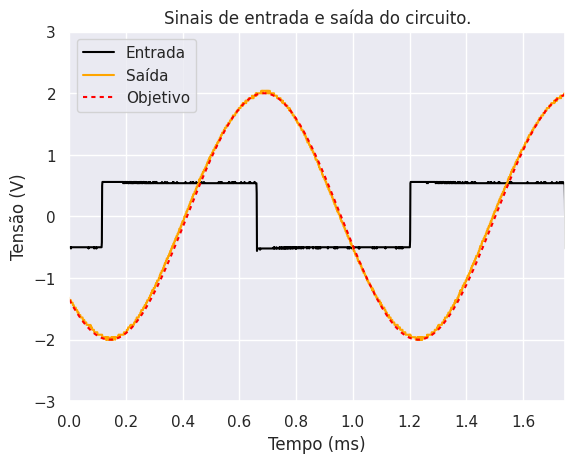

In [5]:
plt.title('Sinais de entrada e saída do circuito.')

sns.lineplot(x=ch1[0] * 1000 + 1.2, y=ch1[1], label='Entrada', color='black')
sns.lineplot(x=ch2[0] * 1000 + 1.2, y=ch2[1], label='Saída', color='orange')

x = np.linspace(0, 1.8E-3, 1000)
sns.lineplot(x=x * 1000, y=2 * np.sin(w0 * x - 2.4), color='red', dashes=(2,2), label='Objetivo')

plt.xlim(0*1000, ch2[0][-1]*1000 + 1.2)
plt.ylim(-3, 3)
plt.xlabel('Tempo (ms)')
plt.ylabel('Tensão (V)')

plt.savefig('plots/waves.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [6]:
v0 = (np.max(ch1[1]) - np.min(ch1[1])) / 2
v0

0.5700000000000001

## Análise de $\chi^2$

In [40]:
senoid = lambda t, A, f, p: A * np.sin(2 * np.pi * f * t + p)

In [59]:
popt, pcov = curve_fit(
	senoid,
	xdata=ch2[0],
	ydata=ch2[1],
	p0=[ 2, 920, 0 ]
)

In [60]:
popt

array([  1.97338299, 921.19758249,  -1.71671952])

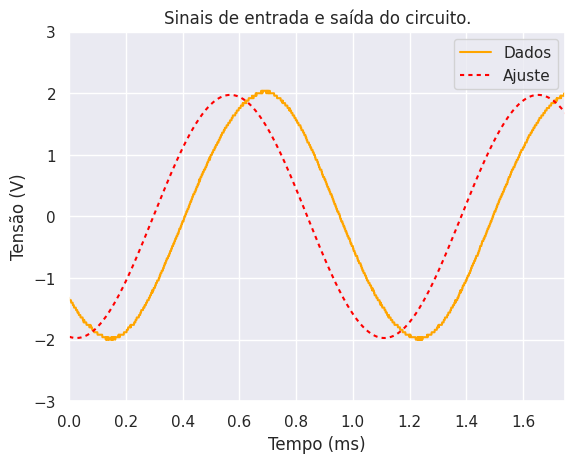

In [61]:
plt.title('Sinais de entrada e saída do circuito.')

sns.lineplot(x=ch2[0] * 1000 + 1.2, y=ch2[1], label='Dados', color='orange')



x = np.linspace(0, 1.8E-3, 1000)
sns.lineplot(x=x * 1000, y=senoid(x, popt[0], popt[1], popt[2]), color='red', dashes=(2, 2), label='Ajuste')

plt.xlim(0*1000, ch2[0][-1]*1000 + 1.2)
plt.ylim(-3, 3)
plt.xlabel('Tempo (ms)')
plt.ylabel('Tensão (V)')

plt.savefig('plots/waves_fit.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

## Expansão de Fourier

In [31]:
def current(w, V0, R, L, C): return V0 / np.sqrt( R**2 + ( w * L - 1 / (w * C) )**2 )
def phase(w, R, L, C): return np.arctan( w * L / R - 1 / (w * R * C) )

In [11]:
N = 1000

w = 920
P = 1 / w

dt = 1 / (N * w)

In [12]:
time = np.linspace(0, P, N)

In [13]:
signal = np.zeros(N) - 1 * v0
signal[N//2:-1] += 2 * v0

In [86]:
yf = fft(signal)
xf = fftfreq(N, d=dt)

In [87]:
n_signal = np.zeros(N)

for i in range(100):
  n_signal -= (2/N) * np.abs(yf[i]) * np.sin(2 * np.pi * xf[i] * time)

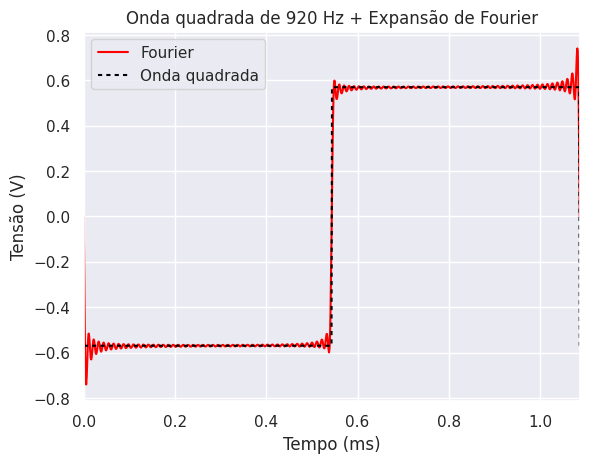

In [88]:
plt.title('Onda quadrada de 920 Hz + Expansão de Fourier')
sns.lineplot(x=time * 1000, y=n_signal, color='red', label='Fourier')
sns.lineplot(x=time * 1000, y=signal, color='black', dashes=(2,2), label='Onda quadrada')
plt.xlabel('Tempo (ms)')
plt.ylabel('Tensão (V)')
plt.xlim(0, 1000 / w)
plt.savefig('plots/squared_wave_fourier.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [89]:
R, L, C = 1000, 27E-3, 1E-6

In [90]:
currs = current(xf[1:N//2], v0, R, L, C)

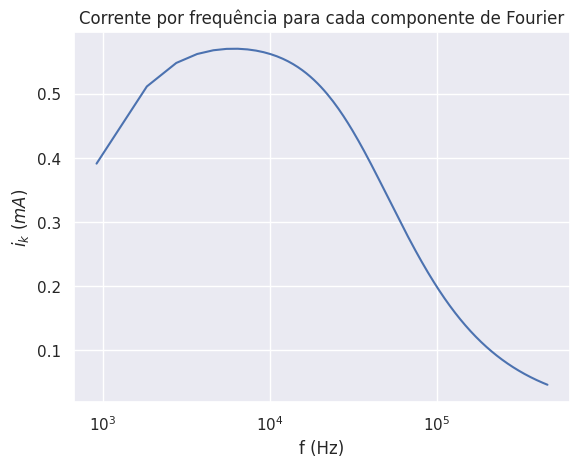

In [95]:
plt.title('Corrente por frequência para cada componente de Fourier')
sns.lineplot(x=xf[1:N//2], y=currs * 1000)
plt.xscale('log')
plt.xlabel('f (Hz)')
plt.ylabel('$i_k$ ($mA$)')
plt.savefig('plots/kth_currente.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

In [37]:
phis = phase(x[1:N//2], R, L, C)

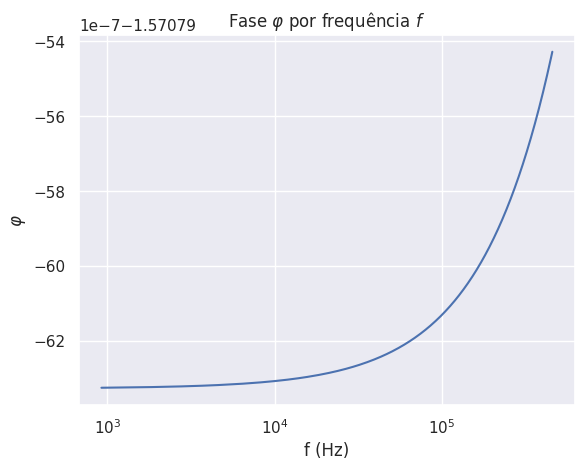

In [40]:
plt.title('Fase $\\varphi$ por frequência $f$')
sns.lineplot(x=xf[1:N//2], y=phis)
plt.xscale('log')
plt.xlabel('f (Hz)')
plt.ylabel('$\\varphi$')
plt.show()

In [96]:
Vk = (2 / N) * np.abs(yf)

In [97]:
Ik = np.zeros(N)

for i in range(N):
	Ik[i] = current(xf[i], Vk[i], R, L, C)

/tmp/ipykernel_3210/4182704637.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  def current(w, V0, R, L, C): return V0 / np.sqrt( R**2 + ( w * L - 1 / (w * C) )**2 )


In [98]:
currs = np.zeros(N)

for i in range(100):
	currs += Ik[i] * np.sin( 2 * np.pi * xf[i] * time )

In [122]:
sin_signal = -(signal + currs * R)

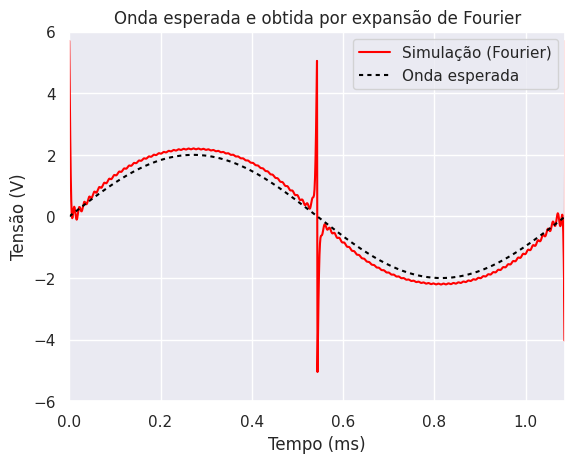

In [134]:
plt.title('Onda esperada e obtida por expansão de Fourier')
sns.lineplot(x=time * 1000, y=10*sin_signal, color='red', label='Simulação (Fourier)')
sns.lineplot(x=time * 1000, y=2 * np.sin(2 * np.pi * w * time), color='black', dashes=(2, 2), label='Onda esperada')
plt.xlim(0, P*1000)
plt.ylim(-6, 6)
plt.xlabel('Tempo (ms)')
plt.ylabel('Tensão (V)')
plt.savefig('plots/out_fourier.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()